# Importações

In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

from joblib import load

In [81]:
model = load('models/rf_best_model.joblib')

train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

target = 'Kingdom_group_encoded'
labels = ['Animalia', 'Bacteria', 'Plantae', 'Virus']

X_train = train_df.drop(target, axis=1)
y_train = train_df[target]

X_test = test_df.drop(target, axis=1)
y_test = test_df[target]

# Global Surrogate Model

Fidelidade mede o quão bem a árvore simples está imitando a Random Forest complexa.

## Árvore de Decisão

Passo a passo para criar o modelo substituto global:
1. Treine a Random Forest no conjunto de dados original.
2. Gere previsões usando a Random Forest para o conjunto de dados de treinamento.
3. Treine uma árvore de decisão simples usando as previsões da Random Forest como rótulos.
4. Avalie a fidelidade do modelo substituto comparando suas previsões com as da Random Forest.

In [91]:
# Usamos o X_train para gerar os "pseudo-rótulos" que o substituto tentará imitar
y_pred_black_box = model.predict(X_train)

# Treinando o Modelo Substituto
surrogate_model = DecisionTreeClassifier(max_depth=3, random_state=42, min_samples_leaf=10)

surrogate_model.fit(X_train, y_pred_black_box)

y_pred_surrogate = surrogate_model.predict(X_train)
fidelity_dt = accuracy_score(y_pred_black_box, y_pred_surrogate)

/Users/jvlm/repositories/model_interpretability_project/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names


In [92]:
print(classification_report(y_train, y_pred_surrogate, target_names=labels))

              precision    recall  f1-score   support

    Animalia       0.82      0.96      0.88      2435
    Bacteria       0.75      0.75      0.75      2350
     Plantae       0.57      0.24      0.33      2018
       Virus       0.56      0.74      0.64      2441

    accuracy                           0.69      9244
   macro avg       0.68      0.67      0.65      9244
weighted avg       0.68      0.69      0.67      9244



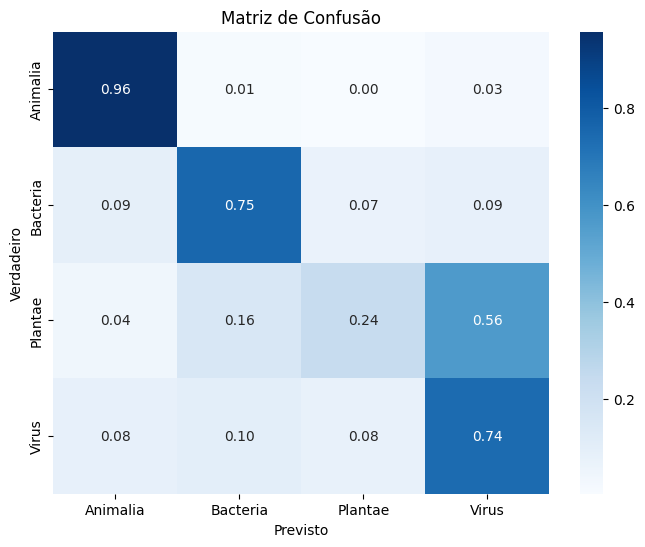

In [93]:
cm = confusion_matrix(y_train, y_pred_surrogate, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

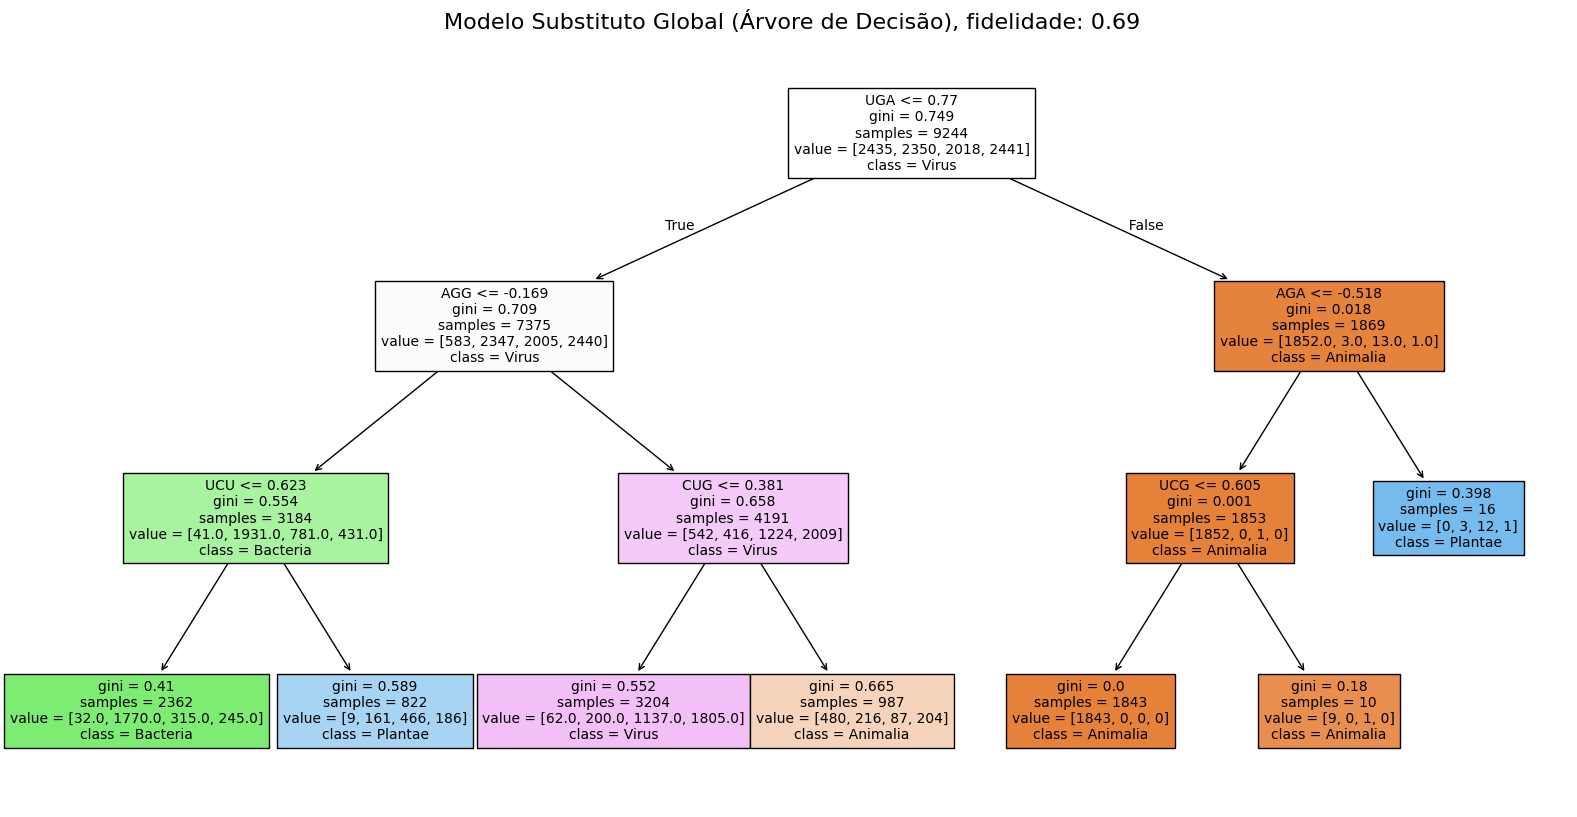

In [94]:
plt.figure(figsize=(20, 10))

plot_tree(surrogate_model, 
          feature_names=X_train.columns, 
          class_names=labels, 
          filled=True, 
          fontsize=10)

plt.title(f"Modelo Substituto Global (Árvore de Decisão), fidelidade: {fidelity_dt:.2f}", fontsize=16)
plt.savefig("global_surrogate_tree.png", dpi=300, bbox_inches='tight')
plt.show()

## Regressão Logística Lasso

In [95]:
surrogate_lr = LogisticRegression(
        penalty='l1',         # Define a regularização L1 (Lasso)
        solver='liblinear',   # Solver que suporta L1
        C=0.1,                # C pequeno = Regularização FORTE (mais zeros)
        random_state=42
    )

# 2. Treinar o pipeline substituto
surrogate_lr.fit(X_train, y_pred_black_box)

# 3. Calcular a Fidelidade
y_pred_surrogate_lr = surrogate_lr.predict(X_train)
fidelity_lr_lasso = accuracy_score(y_pred_black_box, y_pred_surrogate_lr)

print(classification_report(y_train, y_pred_surrogate_lr, target_names=labels))
print(f"Fidelidade (Treino) da Regressão Logística com Lasso (C=0.1): {fidelity_lr_lasso:.4f}")

/Users/jvlm/repositories/model_interpretability_project/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.


              precision    recall  f1-score   support

    Animalia       0.99      0.97      0.98      2435
    Bacteria       0.91      0.94      0.93      2350
     Plantae       0.90      0.88      0.89      2018
       Virus       0.90      0.90      0.90      2441

    accuracy                           0.92      9244
   macro avg       0.92      0.92      0.92      9244
weighted avg       0.93      0.92      0.92      9244

Fidelidade (Treino) da Regressão Logística com Lasso (C=0.1): 0.9249


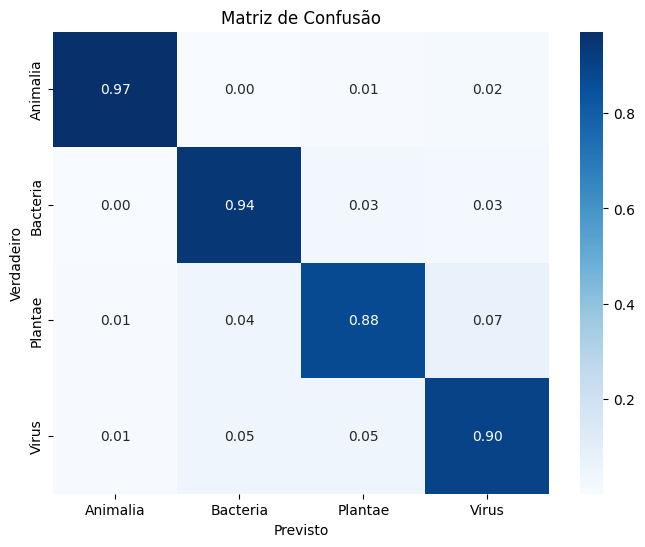

In [97]:
cm = confusion_matrix(y_train, y_pred_surrogate_lr, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=labels, 
            yticklabels=labels)
plt.xlabel('Previsto')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [96]:
# Pegar os nomes das features
feature_names = X_train.columns

print("\n--- Interpretação do Modelo Substituto (Lasso) por Classe ---")

# Iterar sobre os coeficientes e nomes de cada classe
for class_name, coefs in zip(labels, surrogate_lr.coef_):
    
    print(f"\nFeatures mais importantes para a classe: '{class_name}'")
    
    # Criar o DataFrame
    coefficients_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefs
    })
    
    # Ordenar por valor absoluto
    coefficients_df['Abs_Coefficient'] = coefficients_df['Coefficient'].abs()
    coefficients_df = coefficients_df.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Mostrar apenas as features que NÃO foram zeradas
    # (ou o top 10, mesmo que sejam zero)
    top_features = coefficients_df[coefficients_df['Abs_Coefficient'] > 0].head(10)
    
    if top_features.empty:
        print("Nenhuma feature selecionada (regularização muito forte ou classe não informativa)")
    else:
        print(top_features.drop(columns='Abs_Coefficient'))

# Contar o total de coeficientes zerados
total_coefs = surrogate_lr.coef_.size
zero_coefs = (surrogate_lr.coef_ == 0).sum()
print("\n" + "="*50)
print(f"Total de coeficientes: {total_coefs}")
print(f"Coeficientes zerados pelo Lasso: {zero_coefs} ({zero_coefs/total_coefs:.1%})")


--- Interpretação do Modelo Substituto (Lasso) por Classe ---

Features mais importantes para a classe: 'Animalia'
   Feature  Coefficient
63     UGA     3.638748
7      CUG     1.640022
52     CGC    -1.496312
19     GCG    -0.955393
32     UCG    -0.855724
23     CCG    -0.833755
42     CAG     0.747563
41     CAA    -0.637481
12     GUU    -0.590988
34     AGC     0.550197

Features mais importantes para a classe: 'Bacteria'
   Feature  Coefficient
26     GGC     1.544535
9      AUC     1.058178
54     CGG     1.024190
46     UGC    -0.968521
57     GAU     0.901892
53     CGA    -0.836407
45     UGU    -0.794033
59     GAA     0.782268
35     ACU    -0.722362
22     CCA    -0.680883

Features mais importantes para a classe: 'Plantae'
   Feature  Coefficient
63     UGA    -2.639695
37     ACA    -1.528950
2      UUA     1.271029
7      CUG    -1.211033
1      UUC     0.951443
60     GAG     0.807818
36     ACC    -0.765667
50     AAG     0.762374
32     UCG     0.736806
4      CUU 